In [1]:
import os
import sys
AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../..'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

from isolated_plane import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame, read_excel
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Неповоротная НП

# Параметры крыла
l_kr = 6            # размах крыла [м]
l_c = 3             # длина одной консоли [м]
b_b = 1             # бортовая хорда [м]
b_1 = 1             # концевая хорда [м]
chi_0 = radians(0)  # угол стреловидности по передней кромке [рад]
chi_1 = radians(0)      # угол стреловидности по задней кромке [рад]

# Параметры профиля крыла
cc_b = 0.15            # относительная толщина профиля бортовой хорды [-]
cc_1 = 0.15            # относительная толщина профиля концевой хорды [-]
cc = (cc_b + cc_1) / 2  # средняя относительная толщина профиля [-]
xx_c = 0.2              # относительная координата положения максимальной толщины [-]
hb = 1e-5               # относительная высота бугорков профиля [-]
rr_0 = 0                # относительный радиус скругления передней кромки [-]
aa = 0.5                # отношение геометрического параметра профиля `a` в долях рассматриваемой хорды [-]

xx_0 = 0                # относительная координата центра вращения в долях САХ (от носка САХ) относительно которой считаются моменты
xx_t = None             # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях рассматриваемой хорды
T_s = None              # средняя температура поверхности крыла, К

In [4]:
# Расчет геометрических параметров

S_kr = (b_b + b_1) / 2 * l_kr
lambda_kr = l_kr ** 2 / S_kr
zeta_kr = b_1 / b_b
chi_05 = atan(tan(chi_0) - 2 / lambda_kr * (1 / zeta_kr - 1) / (1 / zeta_kr + 1))

In [5]:
def c_x(X, q, S):
    return X / q / S

def c_y(Y, q, S):
    return Y / q / S

def m_z(M_z, q, S, L):
    return M_z / q / S / L

def m_x(M_x, q, S, L):
    return M_x / q / S / L

def c_y_to_c_ya(alpha, cy, cx):
    return cy * np.cos(np.deg2rad(alpha)) - cx * np.sin(np.deg2rad(alpha))

def c_x_to_c_xa(alpha, cy, cx):
    return cy * np.sin(np.deg2rad(alpha)) + cx * np.cos(np.deg2rad(alpha))

In [6]:
# Результаты расчета в Ansys

alpha_Ansys = np.array([ 0,  2,  4,  8, 12, 16, 18])

cya_Ansys = np.array([0.4221, 0.87870555, 1.33116183, 2.20381159, 2.94081187, 3.06659874, 2.98696055])
cxa_Ansys = np.array([0.033533, 0.04445171, 0.06364095, 0.12624057, 0.21696245, 0.37329529, 0.48835367])
mza_Ansys = np.array([0.082072, 0.07468773, 0.06672852, 0.04820573, 0.02087264, 0.05006742, 0.09465106])

# Высота полета
H_Ansys = 0
rho_Ansys = atmo.rho(H_Ansys)
a_Ansys = atmo.a(H_Ansys)

# Параметры невозмущенного потока
M = 0.2

V = M * a_Ansys

q = rho_Ansys * V ** 2 / 2


In [7]:
Airfoil = SubsonicProfile(b_b, cc, xx_c, rr_0, hb, 'naca')
IP = IsolatedPlane(S_kr, lambda_kr, zeta_kr, chi_05, Airfoil)

In [8]:
cya_LiCH, cxa_LiCH, mza_LiCH = [], [], []

alphas = np.linspace(0, 20, 31)

for alf in alphas:
    cxa_LiCH.append(IP.c_xa(M, np.deg2rad(alf)))
    cya_LiCH.append(IP.c_ya(M, np.deg2rad(alf)))

In [9]:
def get_c_y_a_alpha(lam, c_y_a_alpha_airfoil):
    c_y_a_alpha = c_y_a_alpha_airfoil / (1 + c_y_a_alpha_airfoil / np.pi / lam)
    return c_y_a_alpha

c_y_a_alpha_airfoil = (0.9071-0.2141) / (6 - 0)
alpha_alpha = np.linspace(0, 12, 13)

In [10]:
lambda_kr

6.0

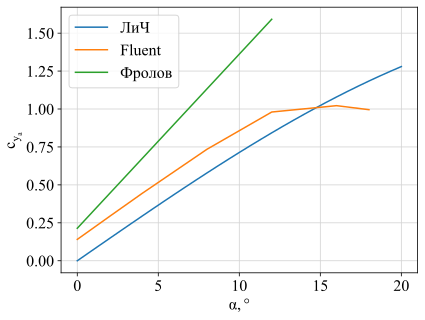

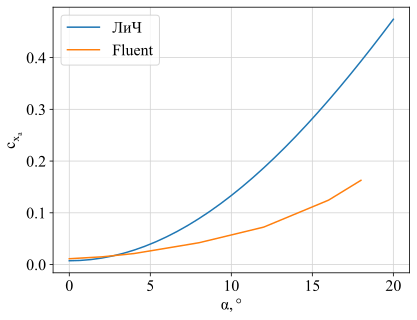

In [11]:
plt.plot(alphas, cya_LiCH, label = '$ЛиЧ$')
plt.plot(alpha_Ansys, cya_Ansys/S_kr*2, label = '$Fluent$')
plt.plot(alpha_alpha, 0.2141+get_c_y_a_alpha(lambda_kr, c_y_a_alpha_airfoil)*alpha_alpha, label = '$Фролов$')

plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.grid(color = 'lightgray')
plt.legend()
plt.show()

plt.plot(alphas, cxa_LiCH, label = '$ЛиЧ$')
plt.plot(alpha_Ansys, cxa_Ansys/S_kr*2, label = '$Fluent$')
plt.plot()

plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.grid(color = 'lightgray')
plt.legend()
plt.show()

In [12]:
68/15.06/1e-6/1e6

4.515272244355909